In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

### Ingest/Clean
***

We'll make sure to exclude columns that aren't useful for analysis and fill NaN's with mode/median depending on column type. In a more strenuous analysis we'd impute missing values and check for outliers.

In [2]:
# Database and Cleaning
def clean_data(df, dataset_type=None):
    # Drop rows with NaN outcomes
    if dataset_type == "train":
        df = df.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='any')

    # Feature selection and NaN handling
    rhs = df.drop(['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
                   'Institute Name', 'Location of Institute', 'Status',
                   'Genetic Disorder', 'Disorder Subclass'], axis=1, errors='ignore')

    for column in rhs.select_dtypes(include='object').columns:
        rhs[column] = rhs[column].replace("-99", np.NaN)
        rhs[column] = rhs[column].fillna(rhs[column].mode().values[0])
        rhs = pd.concat([rhs, pd.get_dummies(rhs[column], drop_first=True, prefix=column)], axis=1)
        rhs = rhs.drop(columns=column)

    for column in rhs.select_dtypes(include=['float64', 'int64']):
        rhs[column] = rhs[column].replace(-99, np.NaN)
        rhs[column] = rhs[column].fillna(rhs[column].median())

    if dataset_type == "train":
        lhs = df[["Genetic Disorder", "Disorder Subclass"]]
        return lhs, rhs
    elif dataset_type == "test":
        return rhs
    else:
        raise Exception("Please define sample as 'test' or 'train'.")

In [5]:
# Clean database
labels, features = clean_data(pd.read_csv("../data/train.csv"), "train")
features.head(5)

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,...,H/O radiation exposure (x-ray)_Yes,H/O substance abuse_No,H/O substance abuse_Not applicable,H/O substance abuse_Yes,Assisted conception IVF/ART_Yes,History of anomalies in previous pregnancies_Yes,Birth defects_Singular,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal
0,2.0,4.760603,35.0,42.0,0.0,0.0,0.0,1.0,0.0,2.0,...,False,True,False,False,False,True,False,False,False,True
2,6.0,4.893297,41.0,22.0,0.0,0.0,0.0,1.0,0.0,4.0,...,True,True,False,False,True,True,True,False,True,False
3,12.0,4.705280,21.0,42.0,0.0,0.0,0.0,1.0,0.0,1.0,...,False,False,True,False,True,True,True,True,False,False
4,11.0,4.720703,32.0,42.0,0.0,0.0,0.0,1.0,0.0,4.0,...,False,False,True,False,True,False,False,False,False,True
5,14.0,5.103188,35.0,42.0,0.0,0.0,0.0,1.0,0.0,0.0,...,False,True,False,False,True,False,False,False,True,False


In [17]:
len(labels)

18047

In [6]:
# Check missing values
features.isna().sum()

Patient Age                                                  0
Blood cell count (mcL)                                       0
Mother's age                                                 0
Father's age                                                 0
Test 1                                                       0
Test 2                                                       0
Test 3                                                       0
Test 4                                                       0
Test 5                                                       0
No. of previous abortion                                     0
White Blood cell count (thousand per microliter)             0
Symptom 1                                                    0
Symptom 2                                                    0
Symptom 3                                                    0
Symptom 4                                                    0
Symptom 5                                              

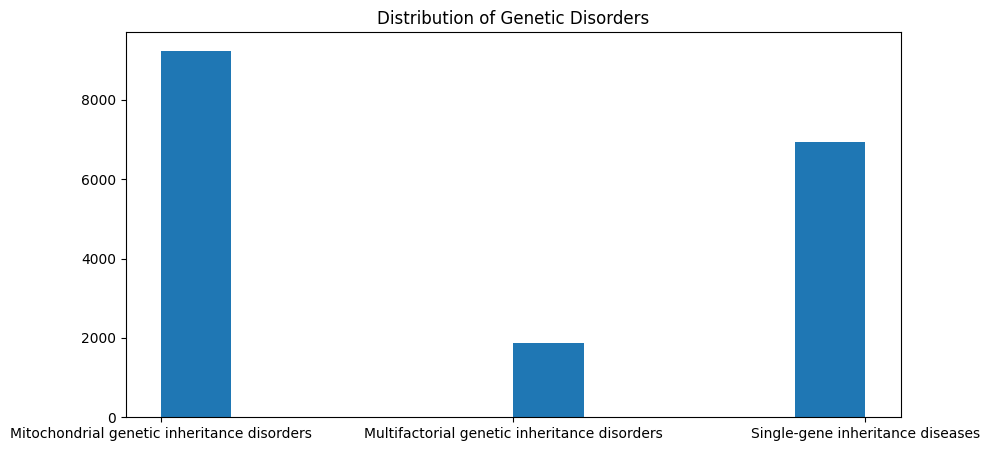

In [7]:
# Visualization of Genetic Disorder
plt.figure(figsize=(10, 5), dpi=100)
plt.hist(labels['Genetic Disorder'])
plt.title("Distribution of Genetic Disorders")
plt.show()

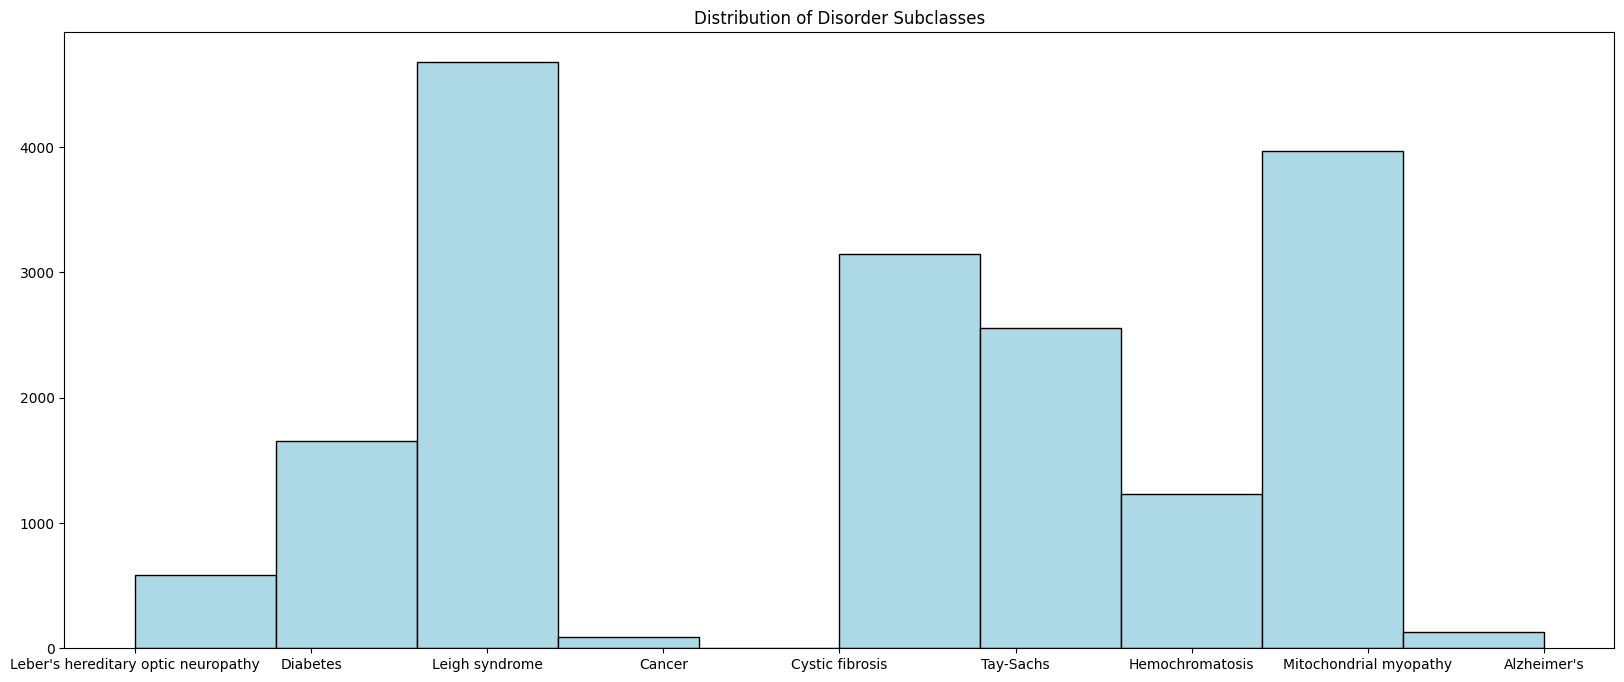

In [8]:
# Visualization of Subclasses
plt.figure(figsize=(20, 8))
plt.hist(labels['Disorder Subclass'], color="lightblue", ec="black")
plt.title("Distribution of Disorder Subclasses")
plt.show()

### Splitting the Dataset
***
We originally wrote this script to work with the provided test set, but it doesn't include labels which makes it unusable for testing model performance.

In [9]:
# Splitting dataset
y_genetic_disorder = labels['Genetic Disorder']
y_disorder_subclass = labels['Disorder Subclass']

x_genetic_disorder_train, x_genetic_disorder_test, y_genetic_disorder_train, y_genetic_disorder_test = \
    train_test_split(features, y_genetic_disorder, test_size=0.2, random_state=42)

x_disorder_subclass_train, x_disorder_subclass_test, y_disorder_subclass_train, y_disorder_subclass_test = \
    train_test_split(features, y_disorder_subclass, test_size=0.2, random_state=42)

### Train
***

We have a specific set of circumstances with this data that will dictate which types of modelling we should use:

1. A mix of categorical and numeric data
2. A categorical outcome we're trying to classify
3. And since we're trying to classify, our methods must be supervised

Surely there are a number of different methods we could test out here, but in the interest of time, let's go with a random forest since decision tree is paticularly suited to mixed data like this, and random forest is superior to a single tree.

In [10]:
# Training
clf_genetic_disorder = RandomForestClassifier(max_depth=9, random_state=42)
clf_genetic_disorder.fit(x_genetic_disorder_train, y_genetic_disorder_train)

clf_disorder_subclass = RandomForestClassifier(max_depth=9, random_state=42)
clf_disorder_subclass.fit(x_disorder_subclass_train, y_disorder_subclass_train)

RandomForestClassifier(max_depth=9, random_state=42)

In [12]:
# Model evaluation
print(f"Genetic Disorder Accuracy on Train Set: {clf_genetic_disorder.score(x_genetic_disorder_train, y_genetic_disorder_train)}")
print(f"Disorder Subclass Accuracy on Train Set: {clf_disorder_subclass.score(x_disorder_subclass_train, y_disorder_subclass_train)}")

Genetic Disorder Accuracy on Train Set: 0.6815820461314678
Disorder Subclass Accuracy on Train Set: 0.6170949643277689


### Test
***

In [13]:
print(f"Genetic Disorder Accuracy on Test Set: {clf_genetic_disorder.score(x_genetic_disorder_test, y_genetic_disorder_test)}")
print(f"Disorder Subclass Accuracy on Test Set: {clf_disorder_subclass.score(x_disorder_subclass_test, y_disorder_subclass_test)}")

Genetic Disorder Accuracy on Test Set: 0.5570637119113574
Disorder Subclass Accuracy on Test Set: 0.37922437673130194


In [15]:
# Additional evaluation metrics
y_genetic_disorder_pred = clf_genetic_disorder.predict(x_genetic_disorder_test)
y_disorder_subclass_pred = clf_disorder_subclass.predict(x_disorder_subclass_test)

In [16]:
print("Genetic Disorder Classification Report:")
print(classification_report(y_genetic_disorder_test, y_genetic_disorder_pred))

Genetic Disorder Classification Report:
                                              precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.56      0.94      0.70      1887
Multifactorial genetic inheritance disorders       0.54      0.09      0.15       353
            Single-gene inheritance diseases       0.55      0.16      0.24      1370

                                    accuracy                           0.56      3610
                                   macro avg       0.55      0.39      0.36      3610
                                weighted avg       0.55      0.56      0.47      3610



In [19]:
print("Disorder Subclass Classification Report:")
print(classification_report(y_disorder_subclass_test, y_disorder_subclass_pred, zero_division=1))

Disorder Subclass Classification Report:
                                     precision    recall  f1-score   support

                        Alzheimer's       1.00      0.00      0.00        24
                             Cancer       1.00      0.00      0.00        18
                    Cystic fibrosis       0.41      0.54      0.47       615
                           Diabetes       0.30      0.06      0.10       311
                    Hemochromatosis       0.45      0.04      0.06       257
Leber's hereditary optic neuropathy       1.00      0.00      0.00       124
                     Leigh syndrome       0.39      0.69      0.50       942
             Mitochondrial myopathy       0.34      0.36      0.35       821
                          Tay-Sachs       0.30      0.14      0.20       498

                           accuracy                           0.38      3610
                          macro avg       0.58      0.20      0.19      3610
                       weighted a